# Import libraries

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Models

In [2]:
from gan import TemporalNetwork, BarGenerator, MuseCritic, MuseGenerator

# TempNetwork

In [3]:
tempnet = TemporalNetwork(n_bars=5)
x = torch.rand(10, 32)
tempnet(x).shape

torch.Size([10, 32, 5])

In [4]:
print('Number of parameters:', sum(p.numel() for p in tempnet.parameters()))

Number of parameters: 199776


# BarGenerator

In [5]:
bargenerator = BarGenerator(
    z_dimension=32,
    hid_features=1152,
    hid_channels=192,
    n_steps_per_bar=48,
    n_pitches=84,
)
a = torch.rand(10, 128)
bargenerator(a).shape

torch.Size([10, 1, 1, 48, 84])

In [6]:
print('Number of parameters:', sum(p.numel() for p in bargenerator.parameters()))

Number of parameters: 347041


# MuseGenerator

In [7]:
generator = MuseGenerator(
    z_dimension=32,
    hid_channels=192 * 2,
    hid_features=1152,
    out_channels=1,
    n_tracks=4,
    n_bars=5,
    n_steps_per_bar=48,
    n_pitches=84,
)

cords = torch.rand(10, 32)
style = torch.rand(10, 32)
melody = torch.rand(10, 4, 32)
groove = torch.rand(10, 4, 32)

generator(cords, style, melody, groove).shape

torch.Size([10, 4, 5, 48, 84])

In [8]:
print('Number of parameters:', sum(p.numel() for p in generator.parameters()))

Number of parameters: 1763044


# MuseCritic

In [9]:
critic = MuseCritic(
    hid_channels=128,
    n_tracks=4,
    n_bars=5,
    n_steps_per_bar=48,
    n_pitches=84,
)
a = torch.rand(10, 4, 5, 48, 84)
critic(a).shape

torch.Size([10, 1])

In [10]:
print('Number of parameters:', sum(p.numel() for p in critic.parameters()))

Number of parameters: 2544129


# Dataset Loader

In [11]:
from torch import Tensor

import torch
from torch import nn
from torch.utils.data import Dataset

import numpy as np


class LPDDataset(Dataset):
    """LPDDataset.

    Parameters
    ----------
    path: str
        Path to dataset.
    """

    def __init__(
        self,
        path: str,
    ) -> None:
        """Initialize."""
        dataset = np.load(path, allow_pickle=True, encoding="bytes")
        self.data_binary = dataset["arr_0"]

    def __len__(self) -> int:
        """Return the number of samples in dataset."""
        return len(self.data_binary)

    def __getitem__(self, index: int) -> Tensor:
        return torch.from_numpy(self.data_binary[index]).float()

In [12]:
from torch.utils.data import DataLoader

dataset = LPDDataset(path='data/lpd/train_x_lpd_5.npz')
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True)

In [14]:
x = next(iter(dataloader))

In [15]:
x.shape

torch.Size([64, 4, 5, 48, 84])

# Define Models

### Generator

In [12]:
generator = generator.to(device)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.9))

### Critic

In [13]:
critic = critic.to(device)
c_optimizer = torch.optim.Adam(critic.parameters(), lr=0.001, betas=(0.5, 0.9))

In [14]:
from gan import initialize_weights

generator = generator.apply(initialize_weights)
critic = critic.apply(initialize_weights)

# Training

In [15]:
from trainer import Trainer

In [16]:
trainer = Trainer(generator, critic, g_optimizer, c_optimizer)

In [17]:
trainer.train(dataloader, epochs=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0/1000 | Generator loss: 283.696 | Critic loss: -59.824 (fake: -113.416, real: -78.906, penalty: 132.498)
Epoch 10/1000 | Generator loss: 1416.081 | Critic loss: -90.970 (fake: -1404.854, real: 1266.070, penalty: 47.814)
Epoch 20/1000 | Generator loss: 1120.073 | Critic loss: -23.049 (fake: -979.125, real: 949.011, penalty: 7.064)
Epoch 30/1000 | Generator loss: 1549.019 | Critic loss: -16.610 (fake: -1421.818, real: 1400.905, penalty: 4.302)
Epoch 40/1000 | Generator loss: 1838.669 | Critic loss: -16.827 (fake: -1572.482, real: 1550.730, penalty: 4.925)
Epoch 50/1000 | Generator loss: -506.726 | Critic loss: -11.550 (fake: 318.523, real: -333.394, penalty: 3.322)
Epoch 60/1000 | Generator loss: 13.024 | Critic loss: -7.195 (fake: -470.180, real: 461.700, penalty: 1.285)
Epoch 70/1000 | Generator loss: -116.581 | Critic loss: -6.527 (fake: -37.536, real: 29.959, penalty: 1.051)
Epoch 80/1000 | Generator loss: -198.498 | Critic loss: -16.204 (fake: 277.828, real: -298.975, penalty

In [18]:
losses = trainer.data.copy()

### Save losses

In [20]:
import pandas as pd

df = pd.DataFrame.from_dict(losses)
#df.to_csv('results.csv', index=False)

### Save models

In [22]:
# generator = generator.eval().cpu()
# critic = critic.eval().cpu()
#torch.save(generator, 'generator_e1000.pt')
#torch.save(critic, 'critic_e1000.pt')

### Plot losses

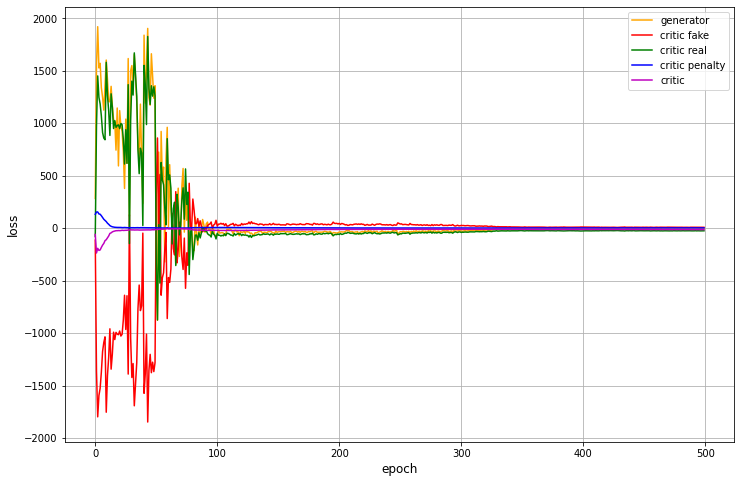

In [31]:
plt.figure(figsize=(12, 8))
plt.plot(losses['gloss'][:500], 'orange', label='generator')
plt.plot(losses['cfloss'][:500], 'r', label='critic fake')
plt.plot(losses['crloss'][:500], 'g', label='critic real')
plt.plot(losses['cploss'][:500], 'b', label='critic penalty')
plt.plot(losses['closs'][:500], 'm', label='critic')
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.grid()
plt.legend()
plt.show()
#plt.savefig('losses.png')

In [17]:
generator = generator.eval().cpu()
#generator = torch.load('generator_e1000.pt')

## Make prediction

In [18]:
chords = torch.rand(1, 32)
style = torch.rand(1, 32)
melody = torch.rand(1, 4, 32)
groove = torch.rand(1, 4, 32)

preds = generator(chords, style, melody, groove).detach()

### Get music data

In [19]:
from data.utils import postProcess

preds = preds.numpy()
music_data = postProcess(preds)

### Save file

In [22]:
filename = 'myexample.midi'
music_data.write('midi', fp=filename)

'myexample.midi'